# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/6-apt_advanced_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to each match

Data that we obtained for each player:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded categorial features:

```
Model Score: 0.9307224848075625

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.93      7416
         Win       0.93      0.93      0.93      7394

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```

# Summary of Results


* Decision Tress is still our best model. Just like history data, when we only add the raw features to the dataset, we get a slight improvement than just adding all of our matchup data to the dataset. Although we are still doing worse than if we didn't add the matchup data to the dataset at all.
```
Model Score: 0.9197164078325456

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810
```




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import re
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup_raw"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018


LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
def filter_features(data: pd.DataFrame):
    # drop all history columns
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all matchup columns that doesn't have percentage or diff
    matchup_columns = [col for col in data.columns if re.search('matchup.+(percentage|diff)', col)]
    data = data.drop(matchup_columns, axis=1)


    print(f'After: data.shape {data.shape}')
    return data


X_train = filter_features(X_train)
X_test = filter_features(X_test)

Before: data.shape (44429, 5293)
After: data.shape (44429, 5259)
Before: data.shape (14810, 5293)
After: data.shape (14810, 5259)


These are the columns that we kept

In [4]:
[col for col in X_train.columns if re.search('matchup', col)]

['p1_matchup_games',
 'p1_matchup_losses',
 'p1_matchup_sets',
 'p1_matchup_wins',
 'p2_matchup_games',
 'p2_matchup_losses',
 'p2_matchup_sets',
 'p2_matchup_wins']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6733288318703579

              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7453
         Win       0.67      0.68      0.68      7357

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4947  2506
Win   2332  5025


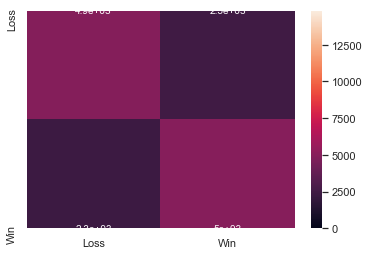

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8287643484132343

              precision    recall  f1-score   support

        Loss       0.82      0.84      0.83      7453
         Win       0.84      0.81      0.83      7357

    accuracy                           0.83     14810
   macro avg       0.83      0.83      0.83     14810
weighted avg       0.83      0.83      0.83     14810

      Loss   Win
Loss  6281  1172
Win   1364  5993


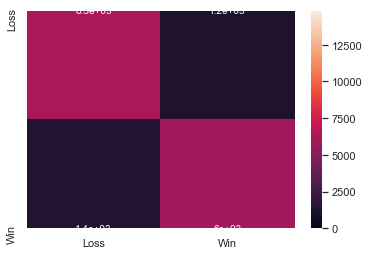

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9197164078325456

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810

      Loss   Win
Loss  6885   568
Win    621  6736


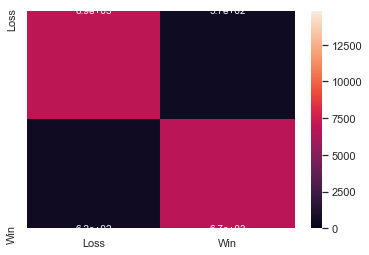

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7941255908170155

              precision    recall  f1-score   support

        Loss       0.77      0.84      0.80      7453
         Win       0.82      0.75      0.78      7357

    accuracy                           0.79     14810
   macro avg       0.80      0.79      0.79     14810
weighted avg       0.80      0.79      0.79     14810

      Loss   Win
Loss  6234  1219
Win   1830  5527


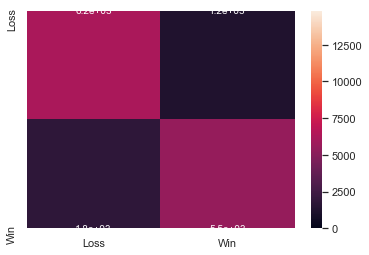

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3157            9.07m
         2           1.2579            8.97m
         3           1.2102            8.78m
         4           1.1722            8.68m
         5           1.1405            8.57m
         6           1.1058            8.48m
         7           1.0785            8.38m
         8           1.0558            8.28m
         9           1.0321            8.19m
        10           1.0159            8.10m
        20           0.8899            7.43m
        30           0.8228            6.46m
        40           0.7841            5.55m
        50           0.7571            4.68m
        60           0.7286            3.73m
        70           0.7182            2.77m
        80           0.6961            1.86m
        90           0.6848           55.74s
       100           0.6717            0.00s


Model Score: 0.8571910871033086

              precision    recall  f1-score   support

        Loss       0.84      0.88      0.86      7453
         Win       0.87      0.84      0.85      7357

    accuracy                           0.86     14810
   macro avg       0.86      0.86      0.86     14810
weighted avg       0.86      0.86      0.86     14810

      Loss   Win
Loss  6551   902
Win   1213  6144


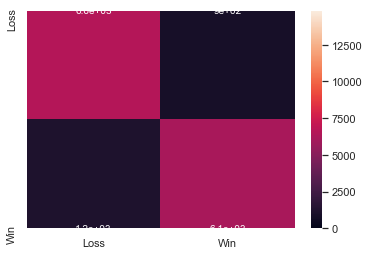

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7512491559756921

              precision    recall  f1-score   support

        Loss       0.73      0.79      0.76      7453
         Win       0.77      0.71      0.74      7357

    accuracy                           0.75     14810
   macro avg       0.75      0.75      0.75     14810
weighted avg       0.75      0.75      0.75     14810

      Loss   Win
Loss  5908  1545
Win   2139  5218


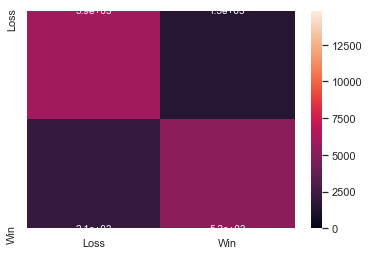

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [29]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,accuracy,classification_report,confusion_matrix,data_file,description,end_year,fit_time_min,model_file,model_name,predict_time_min,start_year,total_time_min
61,0.828764,"{""Loss"": {""precision"": 0.8215827338129497, ""re...","{""0"": {""0"": 6281, ""1"": 1364}, ""1"": {""0"": 1172,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_raw,2018,0.0,../models/kneighborsclassifier-1998-2018-diff-...,KNeighborsClassifier,0.0,1998,0.0
62,0.919716,"{""Loss"": {""precision"": 0.9172661870503597, ""re...","{""0"": {""0"": 6885, ""1"": 621}, ""1"": {""0"": 568, ""...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_raw,2018,0.0,../models/decisiontreeclassifier-1998-2018-dif...,DecisionTreeClassifier,0.0,1998,0.0
63,0.794126,"{""Loss"": {""precision"": 0.7730654761904762, ""re...","{""0"": {""0"": 6234, ""1"": 1830}, ""1"": {""0"": 1219,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_raw,2018,0.0,../models/randomforestclassifier-1998-2018-dif...,RandomForestClassifier,0.0,1998,0.0
64,0.857191,"{""Loss"": {""precision"": 0.8437660999484802, ""re...","{""0"": {""0"": 6551, ""1"": 1213}, ""1"": {""0"": 902, ...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_raw,2018,9.0,../models/gradientboostingclassifier-1998-2018...,GradientBoostingClassifier,0.0,1998,9.0
65,0.751249,"{""Loss"": {""precision"": 0.7341866534112091, ""re...","{""0"": {""0"": 5908, ""1"": 2139}, ""1"": {""0"": 1545,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_raw,2018,1.0,../models/adaboostclassifier-1998-2018-diff-oh...,AdaBoostClassifier,0.0,1998,1.0


Text(0.5, 1.0, 'Model Accuracy')

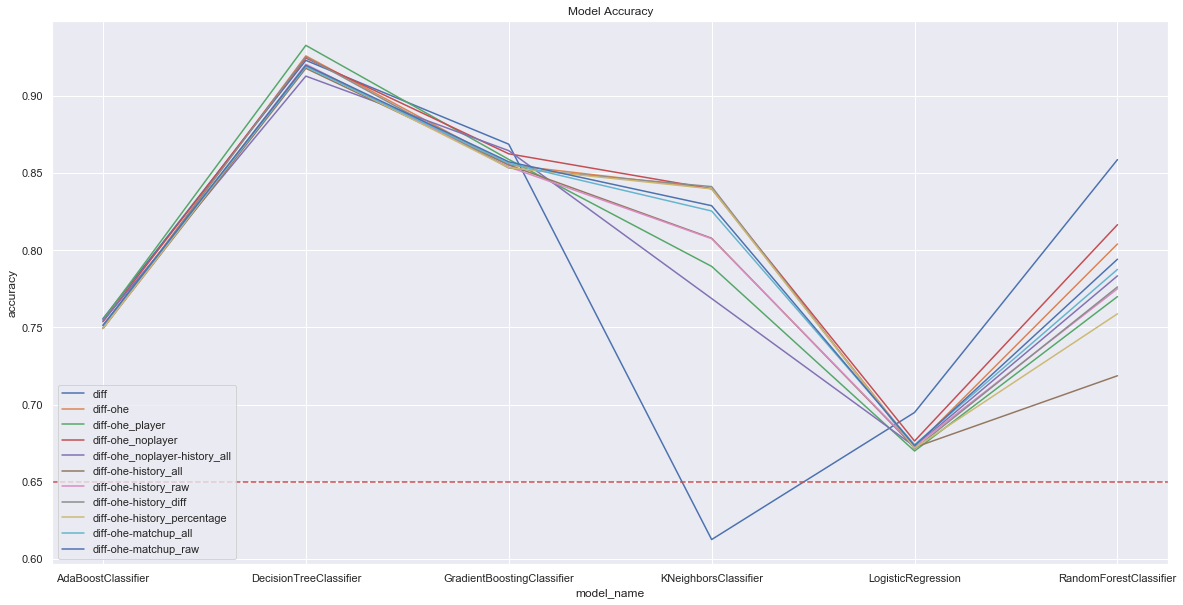

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")

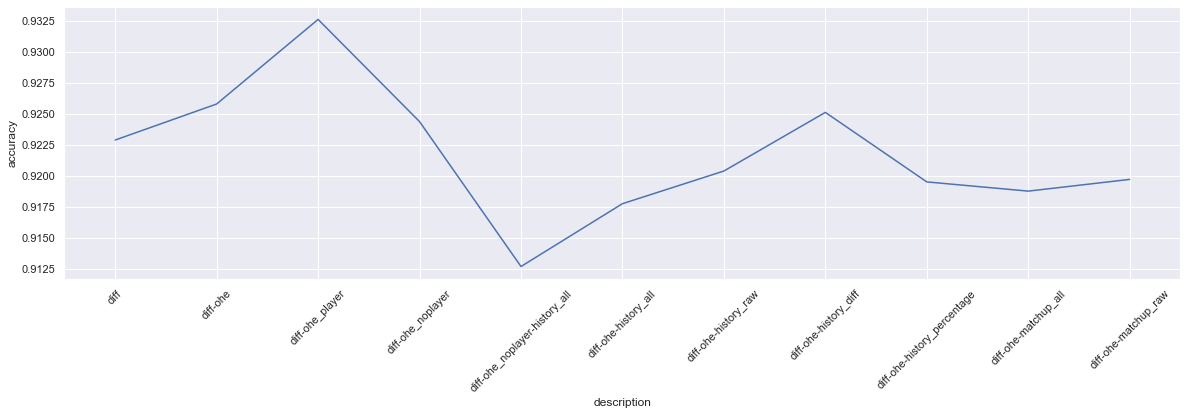

In [31]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
import shap

shap.initjs()

# load the model back
mw = ModelWrapper.get_model_wrapper_from_report(dt_report[dt_report.description == DESCRIPTION])

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)
print('Expected Value:', explainer.expected_value)

(2, 14810, 5259)
Expected Value: [0.49771544337272644, 0.5022845268249512]


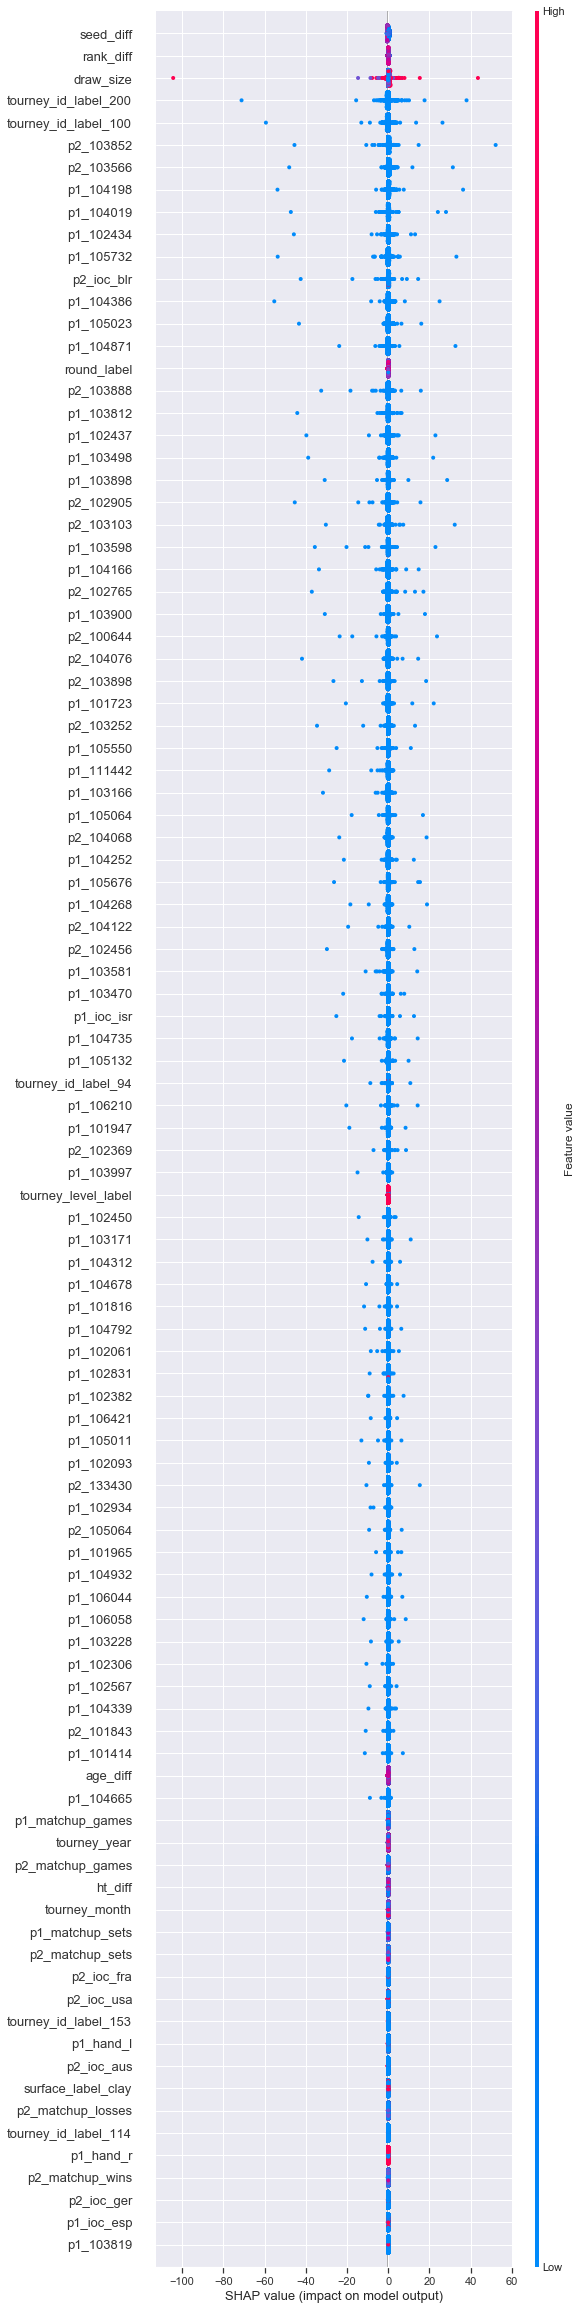

In [33]:
shap.summary_plot(shap_values[1], X_test, max_display=100)

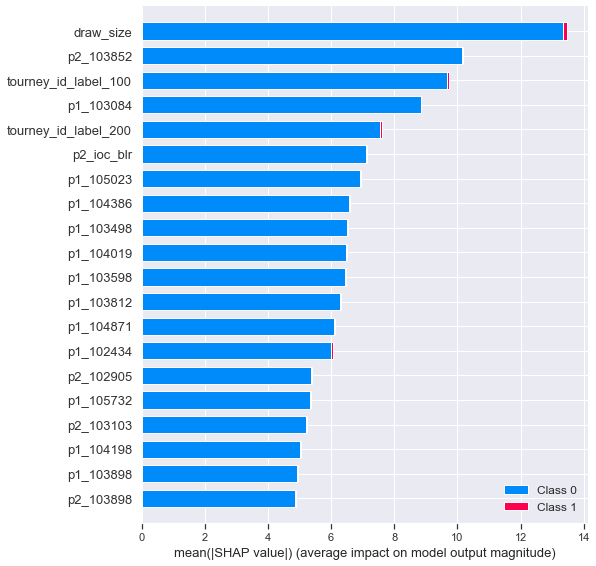

In [34]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")